# Implementing Advantage-Actor Critic (A2C) - 2 pts

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames, stack them together, prepares for PyTorch and normalizes to [0, 1]) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function.

In [4]:
! cp /kaggle/input/helpfunc/* /kaggle/working

In [5]:
!pip install gym[accept-rom-license]==0.22.0
!pip install ale-py==0.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 14.0 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 22.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708362 sha256=63118c084ae7c6d45f5f5689bf106fe380956021c83b3210a1f78768f12d8a04
  Stored in directory: /root/.cache/pip/wheels/42/e8/e8/6dfbc92a1dcd76c1a5e2bb982750fd6b7e792239f46039e6b1
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=41de35dfdd849623a526cd2eb993bf0da87824ffef75d94b01d389fe2a3d4188
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully

In [ ]:
import numpy as np
from atari_wrappers import nature_dqn_env

nenvs = 8    # change this if you have more than 8 CPU ;)

env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=nenvs)

n_actions = env.action_space.spaces[0].n
obs = env.reset()
assert obs.shape == (nenvs, 4, 84, 84)
assert obs.dtype == np.float32

Next, we will need to implement a model that predicts logits of policy distribution and critic value. Use shared backbone. You may use same architecture as in DQN task with one modification: instead of having a single output layer, it must have two output layers taking as input the output of the last hidden layer (one for actor, one for critic). 

Still it may be very helpful to make more changes:
* use orthogonal initialization with gain $\sqrt{2}$ and initialize biases with zeros;
* use more filters (e.g. 32-64-64 instead of 16-32-64);
* use two-layer heads for actor and critic or add a linear layer into backbone;

**Danger:** do not divide on 255, input is already normalized to [0, 1] in our wrappers!

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SharedBackbone(nn.Module):
    def __init__(self, input_channels, num_filters=(32, 64, 64)):
        super(SharedBackbone, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, stride=1)
        
        # Orthogonal initialization with gain sqrt(2)
        nn.init.orthogonal_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv3.weight, gain=nn.init.calculate_gain('relu'))
        
        # Initialize biases with zeros
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.constant_(self.conv2.bias, 0)
        nn.init.constant_(self.conv3.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class ActorCritic(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(ActorCritic, self).__init__()
        
        # Shared backbone
        self.shared_backbone = SharedBackbone(input_channels)
        
        # Actor head
        self.actor_fc = nn.Linear(64 * 7 * 7, 512)  # Modify this according to your desired architecture
        self.actor_logits = nn.Linear(512, num_actions)
        
        # Critic head
        self.critic_fc = nn.Linear(64 * 7 * 7, 512)  # Modify this according to your desired architecture
        self.critic_value = nn.Linear(512, 1)

        # Orthogonal initialization with gain sqrt(2)
        nn.init.orthogonal_(self.actor_fc.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.actor_logits.weight, gain=0.01)  # Small weight initialization for logits
        
        nn.init.orthogonal_(self.critic_fc.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.critic_value.weight, gain=1)  # Critic values can have larger weights
        
        # Initialize biases with zeros
        nn.init.constant_(self.actor_fc.bias, 0)
        nn.init.constant_(self.actor_logits.bias, 0)
        
        nn.init.constant_(self.critic_fc.bias, 0)
        nn.init.constant_(self.critic_value.bias, 0)

    def forward(self, x):
        x = self.shared_backbone(x)
        x = x.view(x.size(0), -1)
        
        # Actor
        actor_x = F.relu(self.actor_fc(x))
        actor_logits = self.actor_logits(actor_x)
        
        # Critic
        critic_x = F.relu(self.critic_fc(x))
        critic_value = self.critic_value(critic_x).squeeze(1)
        
        return actor_logits, critic_value


You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a **dictionary** of all the arrays that are needed to interact with an environment and train the model.

**Important**: "actions" will be sent to environment, they must be numpy array or list, not PyTorch tensor.

Note: you can add more keys, e.g. it can be convenient to compute entropy right here.

In [51]:
import numpy as np
import torch
from torch.distributions import Categorical

class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs):
        '''
        input:
            inputs - numpy array, (batch_size x channels x width x height)
        output: dict containing keys ['actions', 'logits', 'log_probs', 'values']:
            'actions' - selected actions, numpy, (batch_size)
            'logits' - actions logits, tensor, (batch_size x num_actions)
            'log_probs' - log probs of selected actions, tensor, (batch_size)
            'values' - critic estimations, tensor, (batch_size)
        '''
        states = torch.tensor(inputs, dtype=torch.float32)
        logits, values = self.model(states)
        dist = Categorical(logits=logits)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)

        return {
            "actions": actions.numpy(),
            "logits": logits,
            "log_probs": log_probs,
            "values": values
        }

Next we will pass the environment and policy to a runner that collects rollouts from the environment. 
The class is already implemented for you.

In [52]:
from runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'dones'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory, or rollout length. Let's have a look at how it works.

In [53]:
n_actions

6

In [54]:
input_channels = obs.shape[1]
model = ActorCritic(input_channels, n_actions)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=5)

In [55]:
# generates new rollout
trajectory = runner.get_next()

In [56]:
# what is inside
print(trajectory.keys())

dict_keys(['actions', 'logits', 'log_probs', 'values', 'observations', 'rewards', 'dones'])


In [57]:
# Sanity checks
assert 'logits' in trajectory, "Not found: policy didn't provide logits"
assert 'log_probs' in trajectory, "Not found: policy didn't provide log_probs of selected actions"
assert 'values' in trajectory, "Not found: policy didn't provide critic estimations"
assert trajectory['logits'][0].shape == (nenvs, n_actions), "logits wrong shape"
assert trajectory['log_probs'][0].shape == (nenvs,), "log_probs wrong shape"
assert trajectory['values'][0].shape == (nenvs,), "values wrong shape"

for key in trajectory.keys():
    assert len(trajectory[key]) == 5, \
    f"something went wrong: 5 steps should have been done, got trajectory of length {len(trajectory[key])} for '{key}'"

Now let's work with this trajectory a bit. To train the critic you will need to compute the value targets. It will also be used as an estimation of $Q$ for actor training.

You should use all available rewards for value targets, so the formula for the value targets is simple:

$$\hat v(s_t) = \sum_{t'=0}^{T - 1}\gamma^{t'}r_{t+t'} + \gamma^T \hat{v}(s_{t+T}),$$

where $s_{t + T}$ is the latest observation of the environment.

Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 

**Do not forget** to use `trajectory['dones']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step.

**Bonus (+0.5 pts):** implement [Generalized Advantage Estimation (GAE)](https://arxiv.org/pdf/1506.02438.pdf) instead; use $\lambda \approx 0.95$ or even closer to 1 in experiment. 

In [58]:
import numpy as np

class ComputeValueTargets:
    def __init__(self, policy, gamma=0.99):
        self.policy = policy
        self.gamma = gamma

    def __call__(self, trajectory, latest_observation):
        '''
        This method should modify trajectory inplace by adding 
        an item with key 'value_targets' to it
        
        input:
            trajectory - dict from runner
            latest_observation - last state, numpy, (num_envs x channels x width x height)
        '''
        rewards = trajectory['rewards']
        dones = trajectory['dones']
        num_steps = len(rewards)

        # Compute value targets
        value_targets = np.zeros_like(rewards, dtype=np.float32)
        next_value = self.policy.act(latest_observation)["values"].detach().numpy()

        for t in reversed(range(num_steps)):
            next_value = rewards[t] + self.gamma * next_value * (1 - dones[t])
            value_targets[t] = next_value

        trajectory['value_targets'] = value_targets


After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`.

You need to make sure that after this transformation `"log_probs"`, `"value_targets"`, `"values"` are 1-dimensional PyTorch tensors.

In [59]:
import torch

class MergeTimeBatch:
    """ Merges first two axes typically representing time and env batch. """
    def __call__(self, trajectory, latest_observation):
        # Modify trajectory inplace.
        T = len(trajectory['rewards'])
        nenvs = latest_observation.shape[0]
        
        for key in ['log_probs', 'value_targets', 'values']:
            if isinstance(trajectory[key][0], torch.Tensor):
                tensor = torch.cat(trajectory[key], dim=0)  # Concatenate tensors into one
            else:
                tensor = torch.tensor(trajectory[key], dtype=torch.float32)  # Convert to tensor
            
            if tensor.numel() > 1:  # Check if tensor has more than one element
                tensor = tensor.view(T * nenvs)  # Merge time and env batch dimensions
            else:
                tensor = tensor.expand(T * nenvs)  # Expand single-element tensor to match batch size
                
            trajectory[key] = tensor


Let's do more sanity checks!

In [60]:
runner = EnvRunner(env, policy, nsteps=5, transforms=[ComputeValueTargets(policy),
                                                      MergeTimeBatch()])

trajectory = runner.get_next()

In [61]:
# More sanity checks
assert 'value_targets' in trajectory, "Value targets not found"
assert trajectory['log_probs'].shape == (5 * nenvs,)
assert trajectory['value_targets'].shape == (5 * nenvs,)
assert trajectory['values'].shape == (5 * nenvs,)

assert trajectory['log_probs'].requires_grad, "Gradients are not available for actor head!"
assert trajectory['values'].requires_grad, "Gradients are not available for critic head!"

Now is the time to implement the advantage actor critic algorithm itself. You can look into [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and lectures ([part 1](https://www.youtube.com/watch?v=Ds1trXd6pos&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=5), [part 2](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=6)) by Sergey Levine.

In [62]:
import numpy as np

class A2C:
    def __init__(self, policy, optimizer, value_loss_coef=0.25, entropy_coef=0.01, max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.losses = {'policy': [], 'critic': [], 'entropy': []}
        self.advantages = []
        self.value_predictions = []
        self.value_targets = []
        self.raw_rewards = []
        self.gradient_norms = []
        self.actor_losses = []

    def loss(self, trajectory):
        # Compute advantages
        advantages = trajectory['value_targets'] - trajectory['values']

        # Compute policy loss
        policy_loss = -(trajectory['log_probs'] * advantages.detach()).mean()

        # Compute critic loss
        critic_loss = F.mse_loss(trajectory['values'], trajectory['value_targets'])

        # Compute entropy loss
        entropy_loss = -(trajectory['log_probs'].exp() * trajectory['log_probs']).mean()

        # Log losses
        self.losses['policy'].append(policy_loss.item())
        self.losses['critic'].append(critic_loss.item())
        self.losses['entropy'].append(entropy_loss.item())

        # Log additional information
        self.advantages.append(advantages.mean().item())
        self.value_predictions.append(trajectory['values'].mean().item())
        self.value_targets.append(trajectory['value_targets'].mean().item())

        # Compute total loss
        total_loss = policy_loss + self.value_loss_coef * critic_loss - self.entropy_coef * entropy_loss

        return total_loss

    def train(self, runner):
        # Collect trajectory using runner
        trajectory = runner.get_next()

        # Compute loss
        loss = self.loss(trajectory)

        # Perform one step of gradient optimization
        self.raw_rewards.append(np.mean(trajectory['rewards']))
        self.actor_losses.append(self.losses['policy'][-1])
        
        self.optimizer.zero_grad()
        loss.backward()
        grad_norm = clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)  # Clip gradients
        self.gradient_norms.append(grad_norm)
        self.optimizer.step()

    def plot_progress(self):
        if not hasattr(self, 'fig'):
            self.fig, self.axes = plt.subplots(2, 2, figsize=(15, 10))

            self.loss_lines = {}
            self.loss_axes = {}

            self.loss_axes['Losses'] = self.axes[0, 0]
            self.loss_axes['Advantages'] = self.axes[0, 1]
            self.loss_axes['Value Predictions vs Targets'] = self.axes[1, 0]
            self.loss_axes['Reward and Gradient Norm'] = self.axes[1, 1]

            for key in self.losses:
                self.loss_lines[key], = self.loss_axes['Losses'].plot([], label=key)
            self.loss_axes['Losses'].set_xlabel('Step')
            self.loss_axes['Losses'].set_ylabel('Loss')
            self.loss_axes['Losses'].set_title('Losses')
            self.loss_axes['Losses'].legend()

            self.loss_axes['Advantages'].set_xlabel('Step')
            self.loss_axes['Advantages'].set_ylabel('Advantage')
            self.loss_axes['Advantages'].set_title('Advantages')

            self.loss_axes['Value Predictions vs Targets'].set_xlabel('Step')
            self.loss_axes['Value Predictions vs Targets'].set_ylabel('Value')
            self.loss_axes['Value Predictions vs Targets'].set_title('Value Predictions vs Targets')

            self.loss_axes['Reward and Gradient Norm'].set_xlabel('Step')
            self.loss_axes['Reward and Gradient Norm'].set_ylabel('Value')
            self.loss_axes['Reward and Gradient Norm'].set_title('Reward and Gradient Norm')

        for key in self.losses:
            self.loss_lines[key].set_data(range(len(self.losses[key])), self.losses[key])
            self.loss_axes['Losses'].relim()
            self.loss_axes['Losses'].autoscale_view()

        self.loss_axes['Advantages'].clear()
        self.loss_axes['Advantages'].plot(self.advantages)
        self.loss_axes['Advantages'].set_xlabel('Step')
        self.loss_axes['Advantages'].set_ylabel('Advantage')
        self.loss_axes['Advantages'].set_title('Advantages')

        self.loss_axes['Value Predictions vs Targets'].clear()
        self.loss_axes['Value Predictions vs Targets'].plot(self.value_predictions, label='Value Predictions')
        self.loss_axes['Value Predictions vs Targets'].plot(self.value_targets, label='Value Targets')
        self.loss_axes['Value Predictions vs Targets'].set_xlabel('Step')
        self.loss_axes['Value Predictions vs Targets'].set_ylabel('Value')
        self.loss_axes['Value Predictions vs Targets'].set_title('Value Predictions vs Targets')
        self.loss_axes['Value Predictions vs Targets'].legend()

        if len(self.raw_rewards) > 0:
            self.loss_axes['Reward and Gradient Norm'].clear()
            self.loss_axes['Reward and Gradient Norm'].plot(self.raw_rewards, label='Raw Reward')
            self.loss_axes['Reward and Gradient Norm'].plot(self.gradient_norms, label='Gradient Norm')
            self.loss_axes['Reward and Gradient Norm'].plot(self.actor_losses, label='Actor Loss')
            self.loss_axes['Reward and Gradient Norm'].set_xlabel('Step')
            self.loss_axes['Reward and Gradient Norm'].set_ylabel('Value')
            self.loss_axes['Reward and Gradient Norm'].set_title('Reward, Gradient Norm, and Actor Loss')
            self.loss_axes['Reward and Gradient Norm'].legend()

        self.fig.canvas.draw()
        plt.pause(0.001)
        
    def print_progress(self, step):
        print(f"Step: {step}")
        print(f"Policy Loss: {self.losses['policy'][-1]}")
        print(f"Critic Loss: {self.losses['critic'][-1]}")
        print(f"Entropy Loss: {self.losses['entropy'][-1]}")
        print(f"Advantage: {self.advantages[-1]}")
        print(f"Value Prediction: {self.value_predictions[-1]}")
        print(f"Value Target: {self.value_targets[-1]}")
        
        self.plot_progress()


Now you can train your model. For optimization we suggest you use RMSProp with learning rate 7e-4 (you can also linearly decay it to 0), smoothing constant (alpha in PyTorch) equal to 0.99 and epsilon equal to 1e-5.

We recommend to train for at least 10 million environment steps across all batched environments (takes ~3 hours on a single GTX1080 with 8 CPU). It should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last episodes in each environment in the batch) of about 600. **Your goal is to reach 500**.

Notes:
* if your reward is stuck at ~200 for more than 2M steps then probably there is a bug
* if your gradient norm is >10 something probably went wrong
* make sure your `entropy loss` is negative, your `critic loss` is positive
* make sure you didn't forget `.detach` in losses where it's needed
* `actor loss` should oscillate around zero or near it; do not expect loss to decrease in RL ;)
* you can experiment with `nsteps` ("rollout length"); standard rollout length is 5 or 10. Note that this parameter influences how many algorithm iterations is required to train on 10M steps (or 40M frames --- we used frameskip in preprocessing).

In [63]:
# Initialize model, policy, and runner
from torch import optim

model = ActorCritic(input_channels, n_actions)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=10, transforms=[ComputeValueTargets(policy),
                                                      MergeTimeBatch()])

# Choose optimizer
optimizer = optim.RMSprop(model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)

# Initialize A2C algorithm
a2c = A2C(policy, optimizer)


Training progress: 10000/10000000 steps
Step: 10000
Policy Loss: 0.014236122369766235
Critic Loss: 0.16407251358032227
Entropy Loss: 0.2990962862968445
Advantage: 0.008886870928108692
Value Prediction: 0.6773784756660461
Value Target: 0.6862652897834778


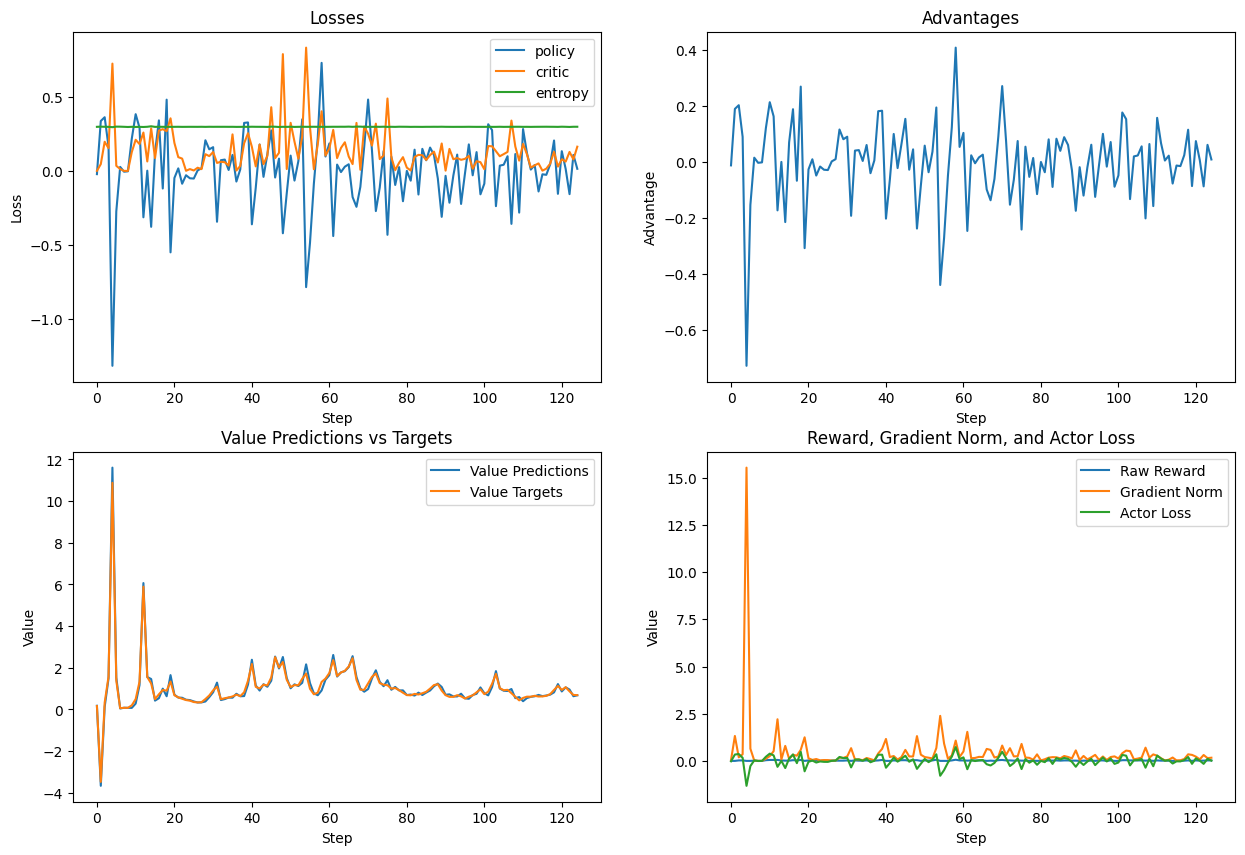

Training progress: 20000/10000000 steps
Step: 20000
Policy Loss: 0.12953060865402222
Critic Loss: 0.11717487871646881
Entropy Loss: 0.29921847581863403
Advantage: 0.07416866719722748
Value Prediction: 1.7499399185180664
Value Target: 1.8241087198257446
Training progress: 30000/10000000 steps
Step: 30000
Policy Loss: -0.06047781556844711
Critic Loss: 0.004388513509184122
Entropy Loss: 0.3005983829498291
Advantage: -0.03309618681669235
Value Prediction: 0.7656676173210144
Value Target: 0.7325713634490967
Training progress: 40000/10000000 steps
Step: 40000
Policy Loss: 0.15377916395664215
Critic Loss: 0.11951571702957153
Entropy Loss: 0.29916054010391235
Advantage: 0.08409003913402557
Value Prediction: 1.4003604650497437
Value Target: 1.4844506978988647
Training progress: 50000/10000000 steps
Step: 50000
Policy Loss: 0.10617504268884659
Critic Loss: 0.060096871107816696
Entropy Loss: 0.3009946346282959
Advantage: 0.06104068085551262
Value Prediction: 1.5046594142913818
Value Target: 1.565

In [ ]:
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_

num_steps = 10000000
total_steps = 0
while total_steps < num_steps:
    a2c.train(runner)
    total_steps += runner.nsteps * runner.nenvs
    
    # Print and plot progress every 10,000 steps
    if total_steps % 10000 == 0:
        print(f"Training progress: {total_steps}/{num_steps} steps")
        a2c.print_progress(total_steps)


# Close environments
env_batch.close()


In [ ]:
# save your model just in case 
torch.save(model.state_dict(), "A2C")    

In [ ]:
env.close()

## Evaluation

In [ ]:
env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, 
                     clip_reward=False, summaries=False, episodic_life=False)

In [ ]:
def evaluate(env, policy, n_games=1, t_max=10000):
    '''
    Plays n_games and returns rewards
    '''
    rewards = []
    
    for _ in range(n_games):
        s = env.reset()
        
        R = 0
        for _ in range(t_max):
            action = policy.act(np.array([s]))["actions"][0]
            
            s, r, done, _ = env.step(action)
            
            R += r
            if done:
                break

        rewards.append(R)
    return np.array(rewards)

In [ ]:
# evaluation will take some time!
sessions = evaluate(env, policy, n_games=30)
score = sessions.mean()
print(f"Your score: {score}")

assert score >= 500, "Needs more training?"
print("Well done!")

In [ ]:
env.close()

## Record

In [ ]:
env_monitor = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, monitor=True,
                             clip_reward=False, summaries=False, episodic_life=False)

In [ ]:
# record sessions
sessions = evaluate(env_monitor, policy, n_games=3)

In [ ]:
# rewards for recorded games
sessions

In [ ]:
env_monitor.close()